In [1]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../Preprocessing')
import numpy as np
import os
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
from imgDataGeneratorLF import *
from preprocessingLF import *
import tensorflow as tf
import keras
from keras import applications
from keras.models import Sequential, Model, Input
from keras.layers import Conv2D, MaxPooling2D, LSTM, Reshape, Permute, TimeDistributed, CuDNNLSTM,LeakyReLU
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization,Lambda
from keras.models import model_from_json

from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.layers.merge import concatenate
from keras.optimizers import Adam
#suppress warnings
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
#Note for Test, Training, and Validation folders, they all need to have same categories
parentPath='/home/livelab/Desktop/NewResizedBinnedLF'
checkAndGeneratePath(parentPath)
testPath='/home/livelab/Desktop/NewResizedBinnedLF/Test'
trainPath='/home/livelab/Desktop/NewResizedBinnedLF/Training'
validPath='/home/livelab/Desktop/NewResizedBinnedLF/Validation'



Length Check on Folder Succeed


In [3]:
trainingGen=imgDataGenerator(trainPath)
validGen=imgDataGenerator(validPath)

In [4]:
x,y=trainingGen.__getitem__(792)

In [5]:
x.shape

(22, 3, 256, 256, 3)

In [6]:
im1=x.astype('uint8')
from matplotlib import pyplot


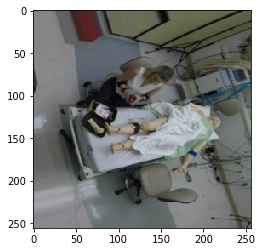

In [16]:
pyplot.imshow(im1[10][0])

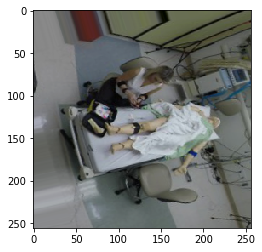

In [17]:
pyplot.imshow(im1[10][1])

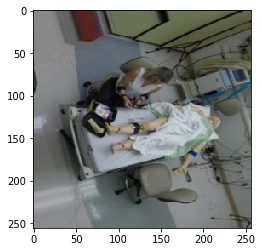

In [18]:
pyplot.imshow(im1[10][2])

In [19]:
a=[1,2,3,4]
a[5:]

[]

In [61]:
def loadCNN(layer_name):
    """
    Load pretrained CNN and lock all features
    """
    inputData=Input(shape=(256, 256, 3))
    model = applications.inception_v3.InceptionV3(weights='imagenet', include_top=False,input_shape = ( 256, 256, 3))
    index=findLayerNumByName(model, layer_name)
    intermediate_model=Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    return intermediate_model

In [59]:
def findLayerNumByName(model, name):
    layerList=model.layers
    return layerList.index(model.get_layer(name))

In [62]:
#Using TimeDistributed Wrapper
inputData=Input(shape=(3, 256, 256, 3))
model=loadCNN('mixed6')
in0 = Lambda(lambda x: x[:, 0, :, :, :])(inputData)
interm0 = model(in0)
interm0=MaxPooling2D()(interm0)
interm0 = Flatten()(interm0)
in1 = Lambda(lambda x: x[:, 1, :, :, :])(inputData)
interm1 = model(in1)
interm1=MaxPooling2D()(interm1)
interm1 = Flatten()(interm1)
in2 = Lambda(lambda x: x[:, 2, :, :, :])(inputData)
interm2 = model(in2)
interm2=MaxPooling2D()(interm2)
interm2 = Flatten()(interm2)

In [63]:

intermediateOut = concatenate([interm0,interm1,interm2])
intermediateOut = Dense(64)(intermediateOut)
intermediateOut = BatchNormalization()(intermediateOut)
intermediateOut = LeakyReLU(alpha=0.2)(intermediateOut)
intermediateOut = Dropout(0.4)(intermediateOut)
intermediateOut = Dense(32)(intermediateOut)
intermediateOut = BatchNormalization()(intermediateOut)
intermediateOut = LeakyReLU(alpha=0.2)(intermediateOut)
intermediateOut = Dropout(0.4)(intermediateOut)

In [64]:
prediction = Dense(24, activation='softmax')(intermediateOut)
optmr = keras.optimizers.adam(lr=0.005, decay = 5e-4)
model_final = Model(input = inputData, output = prediction)
model_final.compile(loss = "categorical_crossentropy", optimizer = optmr, metrics=["accuracy"])
filepath = "CRNN-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
callbacks_list = [checkpoint]

In [65]:
model_final.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           (None, 3, 256, 256,  0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 256, 256, 3)  0           input_43[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 256, 256, 3)  0           input_43[0][0]                   
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 256, 256, 3)  0           input_43[0][0]                   
__________________________________________________________________________________________________
model_20 (

In [11]:
STEP_SIZE_TRAIN=trainingGen.__len__()//trainingGen.batch_size
STEP_SIZE_VAL=validGen.__len__()//validGen.batch_size

In [12]:
with tf.device('GPU:0'):
    model_final.fit_generator(generator=trainingGen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validGen,
                    validation_steps=STEP_SIZE_VAL,
                    callbacks=callbacks_list,
                    use_multiprocessing=True,
                    epochs = 40,
                    workers=6)

Epoch 1/40
1286/1286 [==============================] - 138s 107ms/step - loss: 3.1931 - acc: 0.0467 - val_loss: 12.5406 - val_acc: 0.0735

Epoch 00001: val_acc improved from -inf to 0.07353, saving model to CRNN-01-0.07.hdf5
Epoch 2/40
1286/1286 [==============================] - 133s 104ms/step - loss: 3.1730 - acc: 0.0700 - val_loss: 12.2131 - val_acc: 0.1029

Epoch 00002: val_acc improved from 0.07353 to 0.10294, saving model to CRNN-02-0.10.hdf5
Epoch 3/40
1286/1286 [==============================] - 124s 97ms/step - loss: 3.1710 - acc: 0.0614 - val_loss: 11.9713 - val_acc: 0.0833

Epoch 00003: val_acc did not improve from 0.10294
Epoch 4/40
1286/1286 [==============================] - 126s 98ms/step - loss: 3.1639 - acc: 0.0715 - val_loss: 11.6578 - val_acc: 0.0637

Epoch 00004: val_acc did not improve from 0.10294
Epoch 5/40
1286/1286 [==============================] - 123s 96ms/step - loss: 3.1631 - acc: 0.0692 - val_loss: 11.2743 - val_acc: 0.0588

Epoch 00005: val_acc did not

In [ ]:
model_json = model_final.to_json()
with open("modelmix3.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_final.save_weights("modelmix3.h5")

In [ ]:
json_file = open('saved-model-07-0.16.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_final = model_from_json(loaded_model_json)
# load weights into new model
model_final.load_weights("saved-model-07-0.16.h5")
print("Loaded model from disk")

In [ ]:
model_final.load_weights("saved-model-2-01-0.17.hdf5")

In [ ]:
#manually test model using testset
testGen=imgDataGenerator(testPath)
correct=0
laxcorrect=0
with tf.device('GPU:0'):
    for i in range(193):
        x,y=testGen.__getitem__(i)
        pred=model_final.predict(x)
        pred=pred.reshape((len(pred[0]),24))
        spred=np.sum(pred,axis=0)
        aspred=np.argsort(-spred)
#         print(aspred[:3])
#         print(aspred)
#         print(np.argmax(spred))
#         print(spred)
#         print(np.argmax(y[0][0]))
#         print('**')
        if(np.argmax(y[0][0]) in aspred[:1]):
            correct+=1
        if(np.argmax(y[0][0]) in aspred[:3]):
            laxcorrect+=1    
print('Accuracy of Testing Set: ',correct/193, laxcorrect/193)

In [7]:
#manually test model using testset
testGen=imgDataGenerator(testPath)
correct=0
laxcorrect=0
with tf.device('GPU:0'):
    x,y=testGen.__getitem__(0)
    pred=model_final.predict(x)
    pred=pred.reshape((len(pred[0]),24))
    print(pred[0])
    for p in pred:
        print(np.argmax(p))
    print(np.argmax(y))
    print(y)
print('Accuracy of Testing Set: ',correct/193, laxcorrect/193)

[2.4444167e-02 5.1272457e-04 3.3864358e-03 1.3929498e-02 8.7655790e-04
 3.9349613e-04 2.0848449e-04 2.9556248e-03 2.6248468e-03 2.7816342e-02
 2.7376935e-03 1.1535666e-02 1.9808723e-04 3.3293080e-03 3.6888491e-02
 7.2536373e-01 7.9956785e-04 1.6302963e-03 4.3726549e-03 1.0733723e-03
 3.4537264e-03 1.2404115e-01 6.8205590e-03 6.0759677e-04]
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
14
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Accuracy of Testing Set:  0.0 0.0


## testGen=imgDataGenerator(testPath)
combo=prepdata(testPath)

In [ ]:
a,b=zip(*combo)

In [ ]:
len(a)

In [ ]:
a=[1,2,3,4,5]
np.random.shuffle(a)

In [ ]:
a